<a href="https://colab.research.google.com/github/richardenrico/Pengantar-Deep-Learning/blob/main/Week_2_Deep_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Week 2 - Deep Learning**

Richard Enrico Sulieanto

H071191055

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import pandas as pd
%matplotlib inline

from d2l import tensorflow as d2l

# Backpropagation

Videos watched:


1.   Lecture 9.2 — Neural Networks Learning | Backpropagation Algorithm — [ Machine Learning | Andrew Ng], https://www.youtube.com/watch?v=x_Eamf8MHwU



# Activation Function

## ReLU

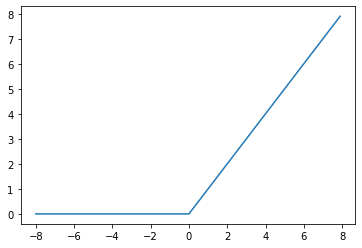

In [ ]:
x = tf.Variable(tf.range(-8.0, 8.0, 0.1), dtype=tf.float32)
y = tf.nn.relu(x)
plt.plot(x.numpy(), y.numpy())

## Gradient Tape

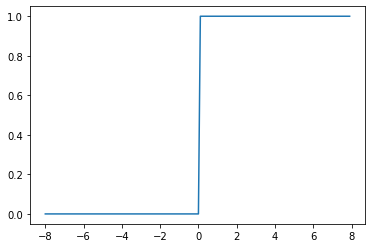

In [ ]:
with tf.GradientTape() as t:
    y = tf.nn.relu(x)
plt.plot(x.numpy(), t.gradient(y, x).numpy())

## Sigmoid

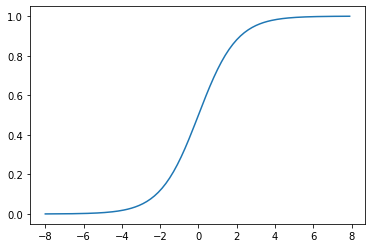

In [ ]:
y = tf.nn.sigmoid(x)
plt.plot(x.numpy(), y.numpy())

## Derirative of Sigmoid

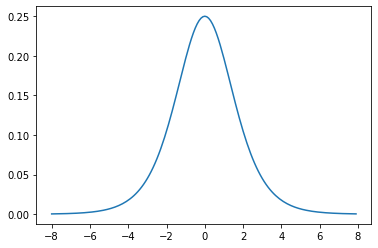

In [ ]:
with tf.GradientTape() as t:
    y = tf.nn.sigmoid(x)
plt.plot(x.numpy(), t.gradient(y, x).numpy())

## Tanh

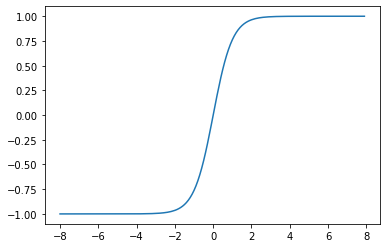

In [ ]:
y = tf.nn.tanh(x)
plt.plot(x.numpy(), y.numpy())

## Derirative of Tanh

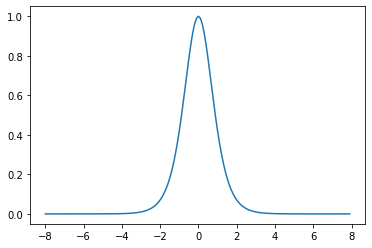

In [ ]:
with tf.GradientTape() as t:
    y = tf.nn.tanh(x)
plt.plot(x.numpy(), t.gradient(y, x).numpy())

# Predicting House Prices on Kaggle

In [ ]:
import hashlib
import os
import tarfile
import zipfile
import requests

#save
DATA_HUB = dict()
DATA_URL = 'http://d2l-data.s3-accelerate.amazonaws.com/'

In [ ]:
def download(name, cache_dir=os.path.join('..', 'data')):  #save
    """Download a file inserted into DATA_HUB, return the local filename."""
    assert name in DATA_HUB, f"{name} does not exist in {DATA_HUB}."
    url, sha1_hash = DATA_HUB[name]
    os.makedirs(cache_dir, exist_ok=True)
    fname = os.path.join(cache_dir, url.split('/')[-1])
    if os.path.exists(fname):
        sha1 = hashlib.sha1()
        with open(fname, 'rb') as f:
            while True:
                data = f.read(1048576)
                if not data:
                    break
                sha1.update(data)
        if sha1.hexdigest() == sha1_hash:
            return fname  # Hit cache
    print(f'Downloading {fname} from {url}...')
    r = requests.get(url, stream=True, verify=True)
    with open(fname, 'wb') as f:
        f.write(r.content)
    return fname

In [ ]:
def download_extract(name, folder=None):  #save
    """Download and extract a zip/tar file."""
    fname = download(name)
    base_dir = os.path.dirname(fname)
    data_dir, ext = os.path.splitext(fname)
    if ext == '.zip':
        fp = zipfile.ZipFile(fname, 'r')
    elif ext in ('.tar', '.gz'):
        fp = tarfile.open(fname, 'r')
    else:
        assert False, 'Only zip/tar files can be extracted.'
    fp.extractall(base_dir)
    return os.path.join(base_dir, folder) if folder else data_dir

def download_all():  #save
    """Download all files in the DATA_HUB."""
    for name in DATA_HUB:
        download(name)

## Accessing and Reading the Dataset

Download Data

In [ ]:
DATA_HUB['kaggle_house_train'] = (  #save
    DATA_URL + 'kaggle_house_pred_train.csv',
    '585e9cc93e70b39160e7921475f9bcd7d31219ce')

DATA_HUB['kaggle_house_test'] = (  #save
    DATA_URL + 'kaggle_house_pred_test.csv',
    'fa19780a7b011d9b009e8bff8e99922a8ee2eb90')

In [ ]:
train_data = pd.read_csv(download('kaggle_house_train'))
test_data = pd.read_csv(download('kaggle_house_test'))

Data shape

In [ ]:
print(train_data.shape)
print(test_data.shape)

(1460, 81)
(1459, 80)


The first four and last two features as well as the label (SalePrice) from the first four examples

In [ ]:
print(train_data.iloc[0:4, [0, 1, 2, 3, -3, -2, -1]])

   Id  MSSubClass MSZoning  LotFrontage SaleType SaleCondition  SalePrice
0   1          60       RL         65.0       WD        Normal     208500
1   2          20       RL         80.0       WD        Normal     181500
2   3          60       RL         68.0       WD        Normal     223500
3   4          70       RL         60.0       WD       Abnorml     140000


In [ ]:
all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]))

## Data Preprocessing

In [ ]:
# If test data were inaccessible, mean and standard deviation could be
# calculated from training data
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
all_features[numeric_features] = all_features[numeric_features].apply(
    lambda x: (x - x.mean()) / (x.std()))
# After standardizing the data all means vanish, hence we can set missing
# values to 0
all_features[numeric_features] = all_features[numeric_features].fillna(0)

In [ ]:
# `Dummy_na=True` considers "na" (missing value) as a valid feature value, and
# creates an indicator feature for it
all_features = pd.get_dummies(all_features, dummy_na=True)
all_features.shape

(2919, 331)

In [ ]:
n_train = train_data.shape[0]
train_features = tf.constant(all_features[:n_train].values, dtype=tf.float32)
test_features = tf.constant(all_features[n_train:].values, dtype=tf.float32)
train_labels = tf.constant(
    train_data.SalePrice.values.reshape(-1, 1), dtype=tf.float32)

## Training

In [ ]:
loss = tf.keras.losses.MeanSquaredError()

def get_net():
    net = tf.keras.models.Sequential()
    net.add(tf.keras.layers.Dense(
        1, kernel_regularizer=tf.keras.regularizers.l2(weight_decay)))
    return net

In [ ]:
def log_rmse(y_true, y_pred):
    # To further stabilize the value when the logarithm is taken, set the
    # value less than 1 as 1
    clipped_preds = tf.clip_by_value(y_pred, 1, float('inf'))
    return tf.sqrt(tf.reduce_mean(loss(
        tf.math.log(y_true), tf.math.log(clipped_preds))))

In [ ]:
def train(net, train_features, train_labels, test_features, test_labels,
          num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []
    train_iter = d2l.load_array((train_features, train_labels), batch_size)
    # The Adam optimization algorithm is used here
    optimizer = tf.keras.optimizers.Adam(learning_rate)
    net.compile(loss=loss, optimizer=optimizer)
    for epoch in range(num_epochs):
        for X, y in train_iter:
            with tf.GradientTape() as tape:
                y_hat = net(X)
                l = loss(y, y_hat)
            params = net.trainable_variables
            grads = tape.gradient(l, params)
            optimizer.apply_gradients(zip(grads, params))
        train_ls.append(log_rmse(train_labels, net(train_features)))
        if test_labels is not None:
            test_ls.append(log_rmse(test_labels, net(test_features)))
    return train_ls, test_ls

# *K*-Fold Cross-Validation

In [ ]:
def get_k_fold_data(k, i, X, y):
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = tf.concat([X_train, X_part], 0)
            y_train = tf.concat([y_train, y_part], 0)
    return X_train, y_train, X_valid, y_valid

In [ ]:
def k_fold(k, X_train, y_train, num_epochs, learning_rate, weight_decay,
           batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net()
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate,
                                   weight_decay, batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i == 0:
            d2l.plot(list(range(1, num_epochs + 1)), [train_ls, valid_ls],
                     xlabel='epoch', ylabel='rmse', xlim=[1, num_epochs],
                     legend=['train', 'valid'], yscale='log')
        print(f'fold {i + 1}, train log rmse {float(train_ls[-1]):f}, '
              f'valid log rmse {float(valid_ls[-1]):f}')
    return train_l_sum / k, valid_l_sum / k

## Model Selection

fold 1, train log rmse 0.170556, valid log rmse 0.156183
fold 2, train log rmse 0.161949, valid log rmse 0.190178
fold 3, train log rmse 0.163656, valid log rmse 0.168163
fold 4, train log rmse 0.167977, valid log rmse 0.154834
fold 5, train log rmse 0.162574, valid log rmse 0.182656
5-fold validation: avg train log rmse: 0.165343, avg valid log rmse: 0.170403


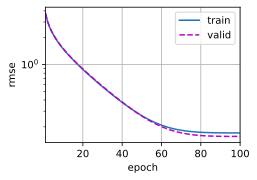

In [ ]:
k, num_epochs, lr, weight_decay, batch_size = 5, 100, 5, 0, 64
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr,
                          weight_decay, batch_size)
print(f'{k}-fold validation: avg train log rmse: {float(train_l):f}, '
      f'avg valid log rmse: {float(valid_l):f}')

## Predictions

In [ ]:
def train_and_pred(train_features, test_features, train_labels, test_data,
                   num_epochs, lr, weight_decay, batch_size):
    net = get_net()
    train_ls, _ = train(net, train_features, train_labels, None, None,
                        num_epochs, lr, weight_decay, batch_size)
    d2l.plot(np.arange(1, num_epochs + 1), [train_ls], xlabel='epoch',
             ylabel='log rmse', xlim=[1, num_epochs], yscale='log')
    print(f'train log rmse {float(train_ls[-1]):f}')
    # Apply the network to the test set
    preds = net(test_features).numpy()
    # Reformat it to export to Kaggle
    test_data['SalePrice'] = pd.Series(preds.reshape(1, -1)[0])
    submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
    submission.to_csv('submission.csv', index=False)

train log rmse 0.162295


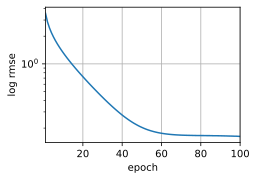

In [ ]:
train_and_pred(train_features, test_features, train_labels, test_data,
               num_epochs, lr, weight_decay, batch_size)